# RESNET50

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import cv2 as cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, f1_score, classification_report
warnings.filterwarnings('ignore')
tf.keras.backend.clear_session()

## Load Images

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
df["id_code"] = df["id_code"].astype(str) + ".png"
label_map = dict(zip(df["id_code"], df["diagnosis"]))
dataset_path = 'colored_images'
X = []
y = []


In [4]:
df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [5]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):
        print(f"🔄 Loading images from {subfolder}...")

        for filename in tqdm(os.listdir(subfolder_path)):
            img_path = os.path.join(subfolder_path, filename)

          
            if filename in label_map:
                label = label_map[filename] 
                
                # Load gambar
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))  
                    X.append(img)
                    y.append(label) 

print(f"Total images loaded: {len(X)}")
print(f"Total labels loaded: {len(y)}")

🔄 Loading images from Mild...


100%|██████████| 370/370 [00:00<00:00, 548.47it/s]


🔄 Loading images from Moderate...


100%|██████████| 999/999 [00:02<00:00, 476.84it/s]


🔄 Loading images from No_DR...


100%|██████████| 1805/1805 [00:02<00:00, 609.73it/s]


🔄 Loading images from Proliferate_DR...


100%|██████████| 295/295 [00:00<00:00, 624.40it/s]


🔄 Loading images from Severe...


100%|██████████| 193/193 [00:00<00:00, 591.86it/s]

Total images loaded: 3662
Total labels loaded: 3662


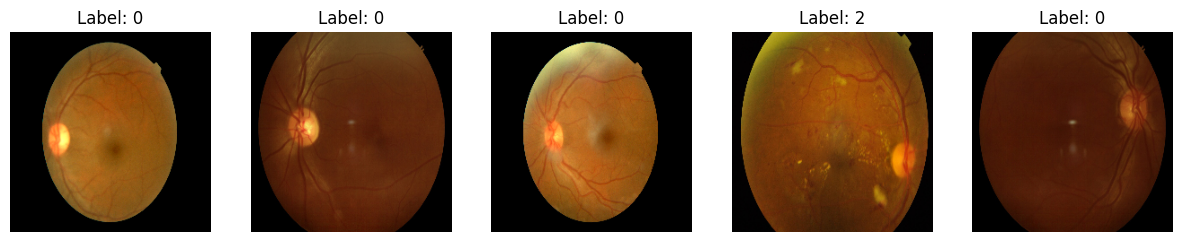

In [6]:
import random

random_indices = random.sample(range(len(X)), 5)
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[index])
    plt.title(f"Label: {y[index]}")
    plt.axis('off')
plt.show()


In [7]:
for subfolder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, subfolder)

    if os.path.isdir(subfolder_path):  # Cek apakah benar-benar folder
        count = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
        print(f'Jumlah gambar pada folder {subfolder}: {count}')

Jumlah gambar pada folder Mild: 370
Jumlah gambar pada folder Moderate: 999
Jumlah gambar pada folder No_DR: 1805
Jumlah gambar pada folder Proliferate_DR: 295
Jumlah gambar pada folder Severe: 193


## Splitting Data

In [8]:
X = np.array(X)
y = np.array(y)

X_train, X_remainingdata, y_train, y_remainingdata = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_remainingdata, y_remainingdata, test_size=0.25, random_state=42, stratify=y_remainingdata)

print(f"Ukuran data training: {len(X_train)}")
print(f"Ukuran data validasi: {len(X_valid)}")
print(f"Ukuran data testing: {len(X_test)}")


Ukuran data training: 2197
Ukuran data validasi: 1098
Ukuran data testing: 367


In [9]:
print(X_train.shape)

(2197, 224, 224, 3)


In [10]:
from collections import Counter
print("\nDistribusi kelas :")
print("Training:", Counter(y_train))
print("Validation:", Counter(y_valid))
print("Testing:", Counter(y_test))


Distribusi kelas :
Training: Counter({0: 1083, 2: 599, 1: 222, 4: 177, 3: 116})
Validation: Counter({0: 541, 2: 300, 1: 111, 4: 88, 3: 58})
Testing: Counter({0: 181, 2: 100, 1: 37, 4: 30, 3: 19})


In [11]:
import albumentations as A
def augment_image(image):
    # Definisikan augmentasi
    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.Emboss(p=0.5),
        # Hapus RandomScale dan PadIfNeeded
    ])

    augmented = augmentations(image=image)['image']
    
    # Resize kembali ke ukuran yang diinginkan
    augmented_resized = cv2.resize(augmented, (224, 224))

    # Pastikan dimensi output konsisten
    if augmented_resized.shape != (224, 224, 3):
        raise ValueError(f"Output shape is not as expected: {augmented_resized.shape}")

    return augmented_resized

In [12]:
X_train_augmented = []

for image in X_train:
    augmented_image = augment_image(image)
    X_train_augmented.append(augmented_image)

# Mengubah kembali ke array NumPy jika diperlukan
X_train_augmented = np.array(X_train_augmented)

## Build Model ResNet50

In [13]:
n_class = 5

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers: 
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_class, activation='softmax')(x)

adam = Adam(lr=0.00001)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', Recall(), Precision()])

In [14]:
from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=n_class)
y_valid_one_hot = to_categorical(y_valid, num_classes=n_class)
y_test_one_hot = to_categorical(y_test, num_classes=n_class )

In [15]:
print(X_train.shape)
print(y_train_one_hot.shape)
print(X_valid.shape)
print(y_valid_one_hot.shape)

(2197, 224, 224, 3)
(2197, 5)
(1098, 224, 224, 3)
(1098, 5)


In [16]:
history = model.fit(X_train_augmented, y_train_one_hot, epochs=32, batch_size=8, validation_data=(X_valid, y_valid_one_hot))

Epoch 1/32
275/275 [==============================] - 17s 39ms/step - loss: 1.4083 - accuracy: 0.4570 - recall: 0.1966 - precision: 0.6025 - val_loss: 1.0945 - val_accuracy: 0.6056 - val_recall: 0.5137 - val_precision: 0.7560
Epoch 2/32
275/275 [==============================] - 10s 37ms/step - loss: 1.1156 - accuracy: 0.6199 - recall: 0.4238 - precision: 0.7490 - val_loss: 0.9474 - val_accuracy: 0.6566 - val_recall: 0.5692 - val_precision: 0.7594
Epoch 3/32
275/275 [==============================] - 10s 37ms/step - loss: 0.9968 - accuracy: 0.6495 - recall: 0.4902 - precision: 0.7810 - val_loss: 0.8613 - val_accuracy: 0.6985 - val_recall: 0.6148 - val_precision: 0.7576
Epoch 4/32
275/275 [==============================] - 10s 37ms/step - loss: 0.9412 - accuracy: 0.6700 - recall: 0.5312 - precision: 0.7966 - val_loss: 0.8244 - val_accuracy: 0.7022 - val_recall: 0.6302 - val_precision: 0.7655
Epoch 5/32
275/275 [==============================] - 10s 38ms/step - loss: 0.8804 - accuracy: 0

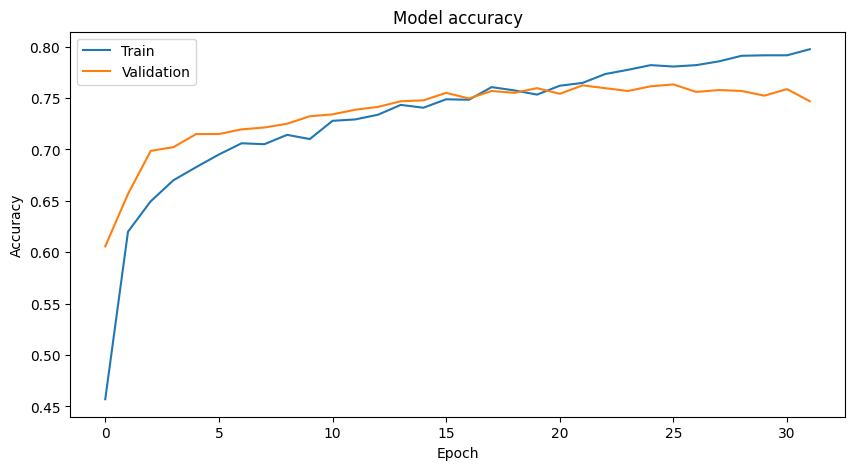

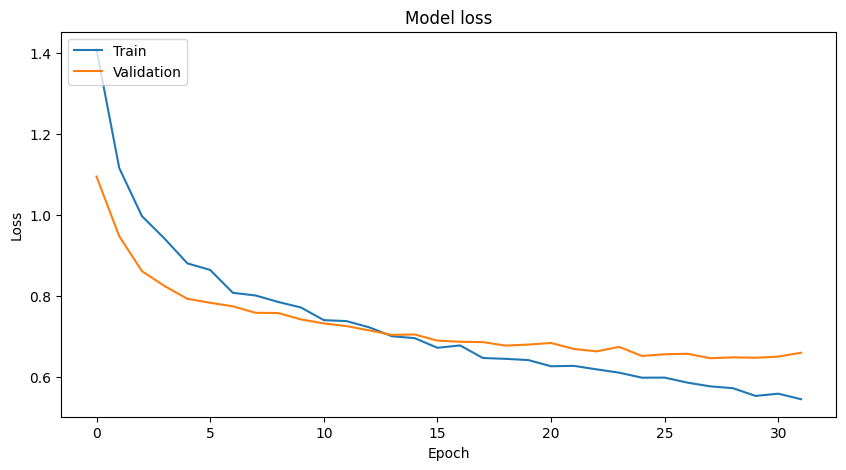

In [17]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Test Evaluate

In [18]:
y_true = np.argmax(y_test_one_hot, axis=1) 
y_pred = model.predict(X_test)  
y_pred = np.argmax(y_pred, axis=1)  

12/12 [==============================] - 2s 74ms/step


In [19]:
print(model.evaluate(X_test, y_test_one_hot))

12/12 [==============================] - 1s 71ms/step - loss: 0.6571 - accuracy: 0.7684 - recall: 0.6975 - precision: 0.8232
[0.6571417450904846, 0.7683923840522766, 0.6975476741790771, 0.8231511116027832]


12/12 [==============================] - 1s 70ms/step


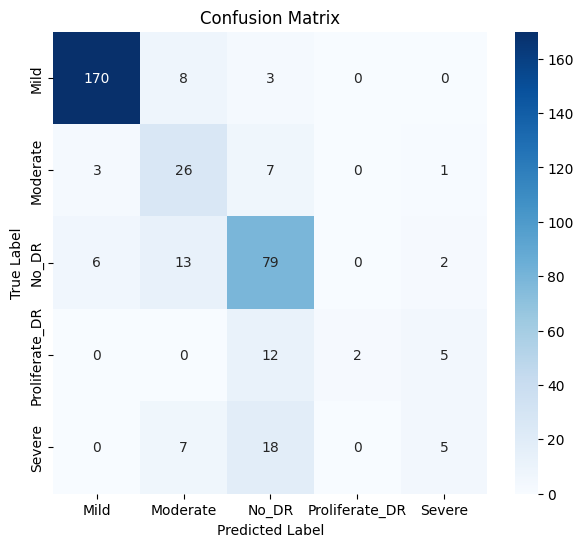

In [20]:
class_names = ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']
y_pred_probs = model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1) 
y_true = np.argmax(y_test_one_hot, axis=1) 

# Buat Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [21]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f'Macro F1 Score: ', macro_f1)

Macro F1 Score:  0.5320737066197403


In [22]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

          Mild       0.95      0.94      0.94       181
      Moderate       0.48      0.70      0.57        37
         No_DR       0.66      0.79      0.72       100
Proliferate_DR       1.00      0.11      0.19        19
        Severe       0.38      0.17      0.23        30

      accuracy                           0.77       367
     macro avg       0.70      0.54      0.53       367
  weighted avg       0.78      0.77      0.75       367

